In [2]:
import geopandas as gpd
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from shapely.geometry import box

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


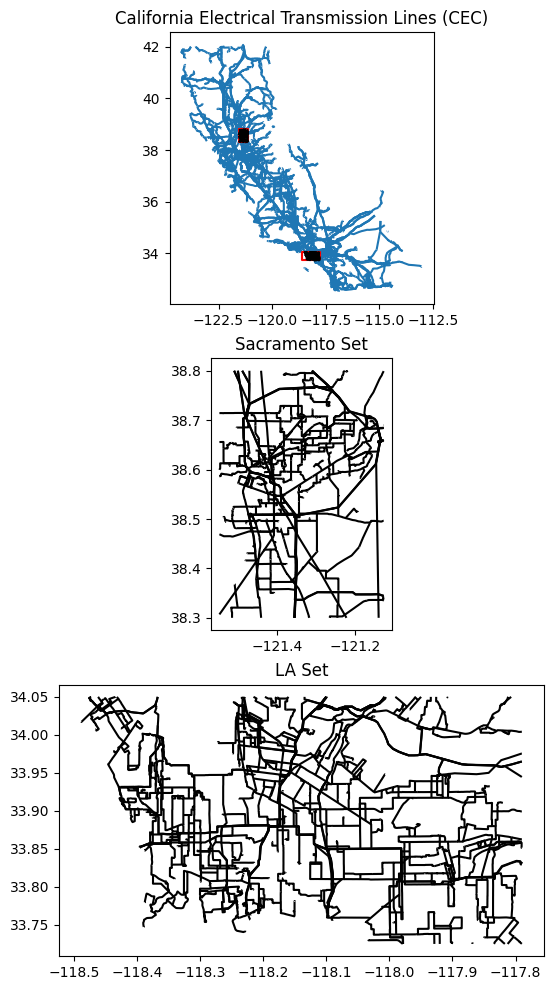

In [3]:
#loads dataframe
df = gpd.read_file("cali1.geojson")

#test filter based on visual #TO CHANGE INTO MUTABLE BOUND
polygon = box(-121.55, 38.3, -121.125, 38.8)
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=df.crs)
clipped = df.clip(polygon)

#test LA
poly2 = box(-118.6,33.725,-117.79,34.05)
p2 = gpd.GeoDataFrame([1], geometry=[poly2], crs=df.crs)
clip2 = df.clip(poly2)

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize = (18, 12))
df.plot(ax=ax1)
poly_gdf.boundary.plot(ax=ax1, color="red")
clipped.plot(ax=ax1,color ="black")
clipped.plot(ax=ax2,color ="black")
ax1.title.set_text('California Electrical Transmission Lines (CEC)')
ax2.title.set_text('Sacramento Set')

p2.boundary.plot(ax=ax1, color="red")
clip2.plot(ax=ax1,color ="black")
clip2.plot(ax=ax3,color ="black")
ax3.title.set_text('LA Set')


#coords = clipped.get_coordinates().to_numpy().tolist()
coords = clip2.get_coordinates().to_numpy().tolist()

In [4]:
#fill up line features with points (increase complexity)
def fill_between_points(pointa, pointb,n):
    (xmin,ymin) = pointa;
    (xmax,ymax) = pointb;
    return [[xmin + i*(xmax-xmin)/n,ymin + i*(ymax-ymin)/n] for i in range(n)] + [[xmax,ymax]]

new = []
for i in range(len(coords)-1):
    new.extend(fill_between_points(coords[i], coords[i+1], 500))
len(new)

9141747

In [5]:
def generate_bin_edges(bounds,l):
    
    (xrange,yrange) = bounds
    (xmin,xmax) = xrange
    (ymin,ymax) = yrange
    
    nx = (xmax-xmin)/l;
    ny = (ymax-ymin)/l;
    
    xlocs = np.linspace(xmin,xmax-l,math.ceil(nx));
    ylocs = np.linspace(ymin,ymax-l,math.ceil(ny));
            
    return (xlocs,ylocs)

def get_count(allcoords,l):
    longs = [x[0] for x in allcoords]
    lats  = [x[1] for x in allcoords]
    
    boundlong = (min(longs), max(longs))
    boundlat = (min(lats), max(lats))
    
    grid, _, _ = np.histogram2d(longs, lats,bins=generate_bin_edges((boundlong,boundlat),l))
    return np.count_nonzero(grid)

def get_dimension(scale,counts):
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(scale),np.log(counts))

    dimension = -slope
    print(dimension)

In [6]:
ls = np.logspace(-2,-5,10)
counts = [0]*len(ls)

for i in range(len(ls)):
    counts[i] = get_count(new,ls[i])
    print(i+1," ",counts[i]) 

1   1731
2   6750
3   21670
4   59187
5   138386
6   283344
7   525024
8   908139
9   1610450
10   2957550


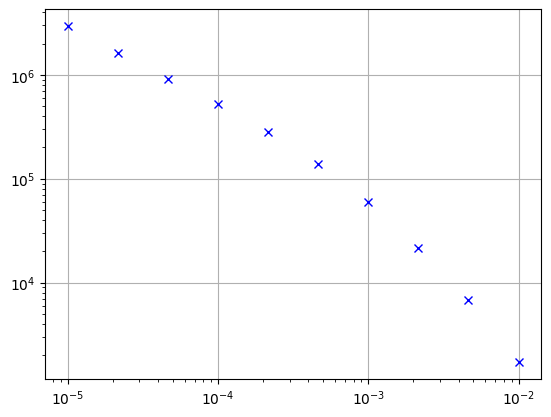

1.0364321270421781


In [10]:
plt.loglog(ls,counts,'bx')
plt.grid("True")
plt.show()
get_dimension(ls,counts)

In [46]:
import folium
import geodatasets

In [ ]:
map_osm = folium.Map(location=[37, -117], zoom_start=6)
map_osm

In [ ]:
for _, r in df.iterrows():
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j)
    geo_j.add_to(map_osm)

map_osm